#### Imports

In [1]:
import pandas as pd
import numpy as np

from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt

from typing import Callable

#### Daten einlsene und als Dict [Sensorname:str, DataFrame] bereitstellen

In [2]:
#json zu DF
df = pd.read_json("data/testdaten.json")
df

,sensor,version,device name,recording epoch time,recording time,recording timezone,platform,appVersion,device id,sensors,...,magneticBearing,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,Metadata,3.0,23049PCD8G,1.755603e+12,2025-08-19_11-26-58,Europe/Berlin,android,1.45.0,fdf9872d-35cd-4b72-8b59-a3a840128702,Accelerometer|Gravity|Gyroscope|Orientation|Ma...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Accelerometer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Accelerometer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Accelerometer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Accelerometer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36652,AccelerometerUncalibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36653,AccelerometerUncalibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36654,AccelerometerUncalibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36655,AccelerometerUncalibrated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_non_Meta = df[1:].copy()
df_non_Meta.dropna(axis=1, how="all",inplace=True)

df_meta = df[0:1].copy()
df_meta.dropna(axis=1, inplace=True)

In [4]:
df_meta.T

,0
sensor,Metadata
version,3.0
device name,23049PCD8G
recording epoch time,1755602818384.0
recording time,2025-08-19_11-26-58
recording timezone,Europe/Berlin
platform,android
appVersion,1.45.0
device id,fdf9872d-35cd-4b72-8b59-a3a840128702
sensors,Accelerometer|Gravity|Gyroscope|Orientation|Ma...


In [5]:
df_non_Meta.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'qz', 'qy', 'qx',
       'qw', 'roll', 'pitch', 'yaw', 'magneticBearing', 'bearingAccuracy',
       'speedAccuracy', 'verticalAccuracy', 'horizontalAccuracy', 'speed',
       'bearing', 'altitude', 'longitude', 'latitude'],
      dtype='object')

In [6]:
df["sensor"].unique()

array(['Metadata', 'Accelerometer', 'Gravity', 'Gyroscope', 'Orientation',
       'Magnetometer', 'Compass', 'Location', 'TotalAcceleration',
       'GameOrientation', 'GeomagneticOrientation',
       'MagnetometerUncalibrated', 'GyroscopeUncalibrated',
       'AccelerometerUncalibrated'], dtype=object)

In [7]:
#Dict mit key=Sensor, Value=DF(Values des Sensors) -> Alle NAN-Spalten löschen -> Index zurücksetzen
sensor_dfs = {sensor: grouped_dfs.dropna(axis=1, how="all").reset_index(drop=True) for sensor, grouped_dfs in df.groupby("sensor")}

# Metadaten aus den Senoren nehmen
if 'Metadata' in sensor_dfs:
    del sensor_dfs['Metadata']

In [8]:
#Liste der Sensoren
sensor_list = list(sensor_dfs.keys())
sensor_list

['Accelerometer',
 'AccelerometerUncalibrated',
 'Compass',
 'GameOrientation',
 'GeomagneticOrientation',
 'Gravity',
 'Gyroscope',
 'GyroscopeUncalibrated',
 'Location',
 'Magnetometer',
 'MagnetometerUncalibrated',
 'Orientation',
 'TotalAcceleration']

In [9]:
sensor_dfs["Accelerometer"]

,sensor,time,seconds_elapsed,z,y,x
0,Accelerometer,1.755603e+18,0.070994,0.000000,0.000000,0.000000
1,Accelerometer,1.755603e+18,0.076042,0.060458,-0.005346,0.004348
2,Accelerometer,1.755603e+18,0.081091,0.123723,0.037533,0.037572
3,Accelerometer,1.755603e+18,0.086139,0.179159,0.035131,0.077884
4,Accelerometer,1.755603e+18,0.091188,0.227628,0.016541,0.065508
...,...,...,...,...,...,...
2627,Accelerometer,1.755603e+18,13.338543,0.883901,-0.208404,-0.040402
2628,Accelerometer,1.755603e+18,13.343593,0.675623,-0.211027,-0.098087
2629,Accelerometer,1.755603e+18,13.348634,0.404627,-0.300560,-0.206992
2630,Accelerometer,1.755603e+18,13.353683,0.306538,-0.298226,-0.361524


In [10]:
for key in sensor_dfs:
    print(f"{key} {sensor_dfs[key].shape}")
    # print(type(key))

Accelerometer (2632, 6)
AccelerometerUncalibrated (5196, 6)
Compass (1323, 4)
GameOrientation (2619, 6)
GeomagneticOrientation (1319, 6)
Gravity (2632, 6)
Gyroscope (5250, 6)
GyroscopeUncalibrated (5204, 6)
Location (9, 12)
Magnetometer (1323, 6)
MagnetometerUncalibrated (1318, 6)
Orientation (2599, 10)
TotalAcceleration (5232, 6)


#### Sensorabtastraten "schätzen" (AI based check):


In [11]:

def estimate_rates_from_elapsed(sensor_dfs, col="seconds_elapsed"):
    results = []
    for sensor, df_s in sensor_dfs.items():
        if col not in df_s.columns or len(df_s) < 2:
            continue

        # Zeitdifferenzen in Sekunden
        dt = df_s[col].diff().dropna()
        dt = dt[dt > 0]

        if dt.empty:
            continue

        median_dt = dt.median()
        mean_dt = dt.mean()
        std_dt = dt.std(ddof=1)

        results.append({
            "sensor": sensor,
            "n_samples": len(df_s),
            "median_dt_ms": median_dt * 1000,   # s → ms
            "mean_dt_ms": mean_dt * 1000,
            "std_dt_ms": std_dt * 1000,
            "approx_rate_hz": 1.0 / median_dt   # Hz ≈ 1 / median(s)
        })

    return pd.DataFrame(results).sort_values("approx_rate_hz", ascending=False).reset_index(drop=True)




In [12]:
rates_df = estimate_rates_from_elapsed(sensor_dfs, col="seconds_elapsed")
rates_df


,sensor,n_samples,median_dt_ms,mean_dt_ms,std_dt_ms,approx_rate_hz
0,AccelerometerUncalibrated,5196,2.524414,2.524491,0.008445,396.131528
1,GyroscopeUncalibrated,5204,2.524414,2.524494,0.008582,396.131528
2,TotalAcceleration,5232,2.524414,2.524291,0.017063,396.131528
3,Gyroscope,5250,2.524414,2.524499,0.022691,396.131528
4,Orientation,2599,5.000000,5.002185,0.095403,200.000000
5,Gravity,2632,5.048828,5.050451,0.075549,198.065764
6,Accelerometer,2632,5.048828,5.050451,0.075549,198.065764
7,GameOrientation,2619,5.048828,5.049001,0.011374,198.065764
8,Compass,1323,10.000000,10.000000,0.000140,100.000000
9,GeomagneticOrientation,1319,10.000000,10.000000,0.000140,100.000000


#### Sensoren wählen und Prüfen:

In [13]:
def select_and_check_sensors(sensor_dfs: dict[str, pd.DataFrame], sensor_list: list[str]) -> dict[str, pd.DataFrame]:
    selected_sensors = {sensor: data for sensor, data in sensor_dfs.items() if sensor in sensor_list}
    for s, df in selected_sensors.items():
        print(f"{s:<20} {len(df):>10} Messpunkte{df.isna().sum().sum():>10} NaNs")

    return selected_sensors

selected_sensors = select_and_check_sensors(sensor_dfs, ["Accelerometer","Gyroscope","GameOrientation","Location"])

Accelerometer              2632 Messpunkte         0 NaNs
GameOrientation            2619 Messpunkte         0 NaNs
Gyroscope                  5250 Messpunkte         0 NaNs
Location                      9 Messpunkte         0 NaNs


In [14]:
for k, v in sensor_dfs.items():
    if "time" not in v.columns:
        print(f"Spalte 'time' ist NICHT vorhanen in {k}")
    if "seconds_elapsed" not in v.columns:
        print(f"Spalte 'seconds_elapsed' ist NICHT vorhanen in {k}")

# --> alle Sonsoren enthalten beide Zeitspalten

In [15]:
for k, v in sensor_dfs.items():
    if "time" in v.columns:
        print(f"-----------------------\n{k}\n{v["time"].head(3)}")

pd.to_datetime(1.755603e18, unit="ns", utc=True)
# --> UNIX time in Nanosekunden!

-----------------------
Accelerometer
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
AccelerometerUncalibrated
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
Compass
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
GameOrientation
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
GeomagneticOrientation
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
Gravity
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
Gyroscope
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
GyroscopeUncalibrated
0    1.755603e+18
1    1.755603e+18
2    1.755603e+18
Name: time, dtype: float64
-----------------------
Location


Timestamp('2025-08-19 11:30:00+0000', tz='UTC')

In [16]:
# ALLGEMEINE Funktion um spätere Funktionen auf alle Sensoren anzuwenden:
def apply_to_all_sensors(func:Callable[[pd.DataFrame], pd.DataFrame], sensor_dfs:dict[str, pd.DataFrame]) -> dict[str, pd.DataFrame]:
    return {name: func(df) for name, df in sensor_dfs.items()}

In [17]:
def time_to_index(df: pd.DataFrame) -> pd.DataFrame:
    df_timeindex = df.copy()
    df_timeindex.set_index(pd.to_datetime(df_timeindex["time"], unit="ns", utc=True),inplace=True)
    df_timeindex.index.name = "time_utc"
    df_timeindex.drop(columns="time", inplace=True)
    # später auf richtige reihenfolge der Zeitstempel, Duplikate und Lücken prüfen
    return df_timeindex



In [18]:
#Datetime Index für alle Sensor DFs
selected_sensors = apply_to_all_sensors(time_to_index,selected_sensors)

In [19]:
selected_sensors["Accelerometer"]

,sensor,seconds_elapsed,z,y,x
time_utc,,,,,
2025-08-19 11:26:58.454994176+00:00,Accelerometer,0.070994,0.000000,0.000000,0.000000
2025-08-19 11:26:58.460042496+00:00,Accelerometer,0.076042,0.060458,-0.005346,0.004348
2025-08-19 11:26:58.465090816+00:00,Accelerometer,0.081091,0.123723,0.037533,0.037572
2025-08-19 11:26:58.470139136+00:00,Accelerometer,0.086139,0.179159,0.035131,0.077884
2025-08-19 11:26:58.475187456+00:00,Accelerometer,0.091188,0.227628,0.016541,0.065508
...,...,...,...,...,...
2025-08-19 11:27:11.722543104+00:00,Accelerometer,13.338543,0.883901,-0.208404,-0.040402
2025-08-19 11:27:11.727592960+00:00,Accelerometer,13.343593,0.675623,-0.211027,-0.098087
2025-08-19 11:27:11.732633856+00:00,Accelerometer,13.348634,0.404627,-0.300560,-0.206992


#### Sensorabtastraten "schätzen",  detailierter (AI based check):


In [20]:
def timing_benchmark(df: pd.DataFrame, high_gap_factor: float = 3.0) -> dict:
    """
    MVP: Qualität der Zeitachse eines einzelnen Sensor-DFs beurteilen.
    Erwartet: DatetimeIndex (UTC, ns). Keine Änderungen am Signal.
    
    Kennzahlen:
      - rows, duration_s
      - n_deltas (Anzahl Abstände), n_nonpos (Δt <= 0)
      - median_dt_ns, mean_dt_ns, std_dt_ns, p95_dt_ns, max_dt_ns
      - approx_hz (1e9 / median_dt_ns)
      - jitter_cv = std_dt_ns / median_dt_ns
      - large_gap_count (Δt > high_gap_factor * median_dt_ns)
      - large_gap_max_ns (größte „große Lücke“)
    """
    out = {
        "rows": len(df),
        "duration_s": np.nan,
        "n_deltas": 0,
        "n_nonpos": 0,
        "median_dt_ns": np.nan,
        "mean_dt_ns": np.nan,
        "std_dt_ns": np.nan,
        "p95_dt_ns": np.nan,
        "max_dt_ns": np.nan,
        "approx_hz": np.nan,
        "jitter_cv": np.nan,
        "large_gap_factor": high_gap_factor,
        "large_gap_count": 0,
        "large_gap_max_ns": np.nan,
    }
    if len(df) < 2:
        return out

    # Gesamtdauer
    out["duration_s"] = (df.index[-1] - df.index[0]).total_seconds()

    # Δt in ns (Index ist datetime64[ns])
    ts_ns = df.index.view("int64")
    dt = np.diff(ts_ns)
    out["n_deltas"] = int(dt.size)
    if dt.size == 0:
        return out

    # nicht-positive Deltas nur für die Statistik zählen, für Kennzahlen ignorieren
    out["n_nonpos"] = int((dt <= 0).sum())
    dt_pos = dt[dt > 0]
    if dt_pos.size == 0:
        return out

    # robuste „typische Schrittweite“
    median_dt_ns = float(np.median(dt_pos))
    mean_dt_ns   = float(np.mean(dt_pos))
    std_dt_ns    = float(np.std(dt_pos, ddof=1)) if dt_pos.size > 1 else 0.0
    p95_dt_ns    = float(np.quantile(dt_pos, 0.95))
    max_dt_ns    = float(np.max(dt_pos))

    out["median_dt_ns"] = median_dt_ns
    out["mean_dt_ns"]   = mean_dt_ns
    out["std_dt_ns"]    = std_dt_ns
    out["p95_dt_ns"]    = p95_dt_ns
    out["max_dt_ns"]    = max_dt_ns
    out["approx_hz"]    = (1e9 / median_dt_ns) if median_dt_ns > 0 else np.nan
    out["jitter_cv"]    = (std_dt_ns / median_dt_ns) if median_dt_ns > 0 else np.nan

    # große Lücken gegenüber „typischem“ Schritt
    thr = high_gap_factor * median_dt_ns
    large = dt_pos[dt_pos > thr]
    out["large_gap_count"]  = int(large.size)
    out["large_gap_max_ns"] = float(np.max(large)) if large.size else np.nan
    return out


def timing_benchmark_all(sensors: dict[str, pd.DataFrame], high_gap_factor: float = 3.0) -> pd.DataFrame:
    rows = []
    for name, df in sensors.items():
        m = timing_benchmark(df, high_gap_factor=high_gap_factor)
        m["sensor"] = name
        rows.append(m)
    cols = ["sensor","rows","duration_s","n_deltas","n_nonpos",
            "median_dt_ns","mean_dt_ns","std_dt_ns","p95_dt_ns","max_dt_ns",
            "approx_hz","jitter_cv","large_gap_factor","large_gap_count","large_gap_max_ns"]
    return pd.DataFrame(rows)[cols].sort_values("sensor").reset_index(drop=True)


In [21]:
bench = timing_benchmark_all(selected_sensors, high_gap_factor=3.0)
bench  # im Notebook als Tabelle anzeigen lassen

,sensor,rows,duration_s,n_deltas,n_nonpos,median_dt_ns,mean_dt_ns,std_dt_ns,p95_dt_ns,max_dt_ns,approx_hz,jitter_cv,large_gap_factor,large_gap_count,large_gap_max_ns
0,Accelerometer,2632,13.287737,2631,0,5048832.0,5.050451e+06,7.554929e+04,5.067520e+06,8.879872e+06,198.065612,0.014964,3.0,0,NaN
1,GameOrientation,2619,13.218285,2618,0,5048832.0,5.049001e+06,1.137924e+04,5.067302e+06,5.105152e+06,198.065612,0.002254,3.0,0,NaN
2,Gyroscope,5250,13.251094,5249,0,2524416.0,2.524499e+06,2.268820e+04,2.536448e+06,3.608576e+06,396.131224,0.008988,3.0,0,NaN
3,Location,9,11.135593,8,0,884392192.0,1.391949e+09,1.929912e+09,4.325757e+09,6.116424e+09,1.130720,2.182191,3.0,1,6.116424e+09


#### Auf feste Zeiten resamplen:

In [22]:
STEPS = "5ms" #200hz

def resample_imu_sensors(df: pd.DataFrame, step: str = STEPS) -> pd.DataFrame:
    #out = df.resample(step).mean(numeric_only=True)
    out = df.resample(step, origin="epoch", label="left", closed="left").mean(numeric_only=True)
    out = out.interpolate(method="time", limit_direction="both")
    return out

def resample_location(df: pd.DataFrame, step: str = STEPS) -> pd.DataFrame:
    # resample speziell für die langsame abtastrate der Location
    out = df.resample(step, origin="epoch", label="left", closed="left").ffill()
    return out

def resample_selected_sensors(selected: dict[str, pd.DataFrame], step: str = STEPS) -> dict[str, pd.DataFrame]:
    out: dict[str, pd.DataFrame] = {}
    for name, df in selected.items():
        if name == "Location":
            out[name] = resample_location(df, step)
        else:
            out[name] = resample_imu_sensors(df, step)

    # Quick-Sanity: haben alle denselben Index?
    if not out:
        return out
    idx0 = next(iter(out.values())).index
    for n, d in out.items():
        if not d.index.equals(idx0):
            # Für MVP nicht hart abbrechen, nur sichtbar machen:
            print(f"⚠️ Index von {n} weicht ab (Länge={len(d)}, Start={d.index[0]}, Ende={d.index[-1]})")
            
    return out



In [23]:
selected_sensors.keys()

dict_keys(['Accelerometer', 'GameOrientation', 'Gyroscope', 'Location'])

In [24]:
resampled_sensors = resample_selected_sensors(selected_sensors,STEPS)
#### NEXT:
#### Alle Senoren auf die länge vom ersten bis letzen GPS-fix aus "Locations" schneiden...  

⚠️ Index von GameOrientation weicht ab (Länge=2645, Start=2025-08-19 11:26:58.520000+00:00, Ende=2025-08-19 11:27:11.740000+00:00)
⚠️ Index von Gyroscope weicht ab (Länge=2651, Start=2025-08-19 11:26:58.490000+00:00, Ende=2025-08-19 11:27:11.740000+00:00)
⚠️ Index von Location weicht ab (Länge=2228, Start=2025-08-19 11:26:59.690000+00:00, Ende=2025-08-19 11:27:10.825000+00:00)


In [25]:
resampled_sensors["Location"].columns

Index(['sensor', 'seconds_elapsed', 'bearingAccuracy', 'speedAccuracy',
       'verticalAccuracy', 'horizontalAccuracy', 'speed', 'bearing',
       'altitude', 'longitude', 'latitude'],
      dtype='object')

#### Alle Sonsoren auf gemeinsamen (Location) Index slicen:
Für den MVP werden die Start und Endzeitpunkte auf den ersten und letzten GPS-Fix gesetzt, später muss das etwas intelligenter Implementiert werden.

In [26]:
def location_window_no_nans(location_df: pd.DataFrame) -> tuple[pd.Timestamp, pd.Timestamp]:
    """
    Gibt (t0, t1) zurück:
      t0 = erster Index, dessen gesamte Zeile keine NaNs enthält
      t1 = letzter Index, dessen gesamte Zeile keine NaNs enthält

    Erwartet: Location hat bereits DatetimeIndex (z. B. nach time_to_index + Resampling).

    Hinweise:
    - MVP: keine Rücksicht auf Accuracy-Werte (horizontal/verticalAccuracy, etc.).
      Ein strengerer Fix könnte später z.B. eine Mindestgenauigkeit erfordern.
    - Gibt zusätzlich Info aus, wie viele Sekunden vorne/hinten abgeschnitten werden.
    """
    if len(location_df) == 0:
        raise ValueError("Location ist leer.")

    # Falls eine keine Zeilen ohne NaNs geben sollte
    valid = location_df.notna().all(axis=1)
    if not valid.any():
        raise ValueError("Keine vollständig NaN-freie Zeile in Location gefunden.")

    t0 = valid.idxmax()           # erster True-Index
    t1 = valid[::-1].idxmax()     # letzter True-Index

    # Debug-Infos: abgeschnittene Zeiträume
    total = (location_df.index[-1] - location_df.index[0]).total_seconds()
    cut_front = (t0 - location_df.index[0]).total_seconds()
    cut_back = (location_df.index[-1] - t1).total_seconds()
    print(f"⏱️ GPS-Window: Gesamt {total:.2f} s, vorne abgeschnitten {cut_front:.2f} s, hinten {cut_back:.2f} s")

    #TypeCheck t0, t1
    print("\n")
    print("Type of returned values:")
    print(type(t0))
    print(type(t1))
    

    return t0, t1

In [27]:
start, end = location_window_no_nans(resampled_sensors["Location"])

⏱️ GPS-Window: Gesamt 11.13 s, vorne abgeschnitten 0.01 s, hinten 0.00 s


Type of returned values:
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
def slice_all_sensors(sensors:dict[str, pd.DataFrame], start:pd.Timestamp, end:pd.Timestamp) -> dict[str, pd.DataFrame]:
    sliced_sensors = {name : df.loc[start:end] for name, df in sensors.items()}
    return sliced_sensors

In [29]:
sliced_sensors = slice_all_sensors(resampled_sensors, start, end)

for k, v in sliced_sensors.items():
    print(f"{k:<16} {len(v):>6} rows  Start={v.index[0]}  Ende={v.index[-1]}")

Accelerometer      2227 rows  Start=2025-08-19 11:26:59.695000+00:00  Ende=2025-08-19 11:27:10.825000+00:00
GameOrientation    2227 rows  Start=2025-08-19 11:26:59.695000+00:00  Ende=2025-08-19 11:27:10.825000+00:00
Gyroscope          2227 rows  Start=2025-08-19 11:26:59.695000+00:00  Ende=2025-08-19 11:27:10.825000+00:00
Location           2227 rows  Start=2025-08-19 11:26:59.695000+00:00  Ende=2025-08-19 11:27:10.825000+00:00


### Features für die jeweiligen Sensoren erstellen:

#### Dataframe mit variablen Zeitfenstern für die Features:

In [30]:
### Globale Parameter:

WINDOW_LEN = 2.0 #Intervalllänge in Sekunden
WINDOW_STEP = 1.0 #Steps je Intervall in Sekunden

L = pd.to_timedelta(WINDOW_LEN,  unit="s")
S = pd.to_timedelta(WINDOW_STEP, unit="s")
# z.b. window_len = 2 und window_steps = 1 --> jede Sekunde ein 2 Sekunden Fenster =  50% Überlappung


In [31]:
# 1) Referenzindex der Sensoren
ref_df = next(iter(sliced_sensors.values())) # Index des ersten Sonsors, da alle Sensoren auf den gleichen Index gesliced sind.
idx = ref_df.index
print("Referenzindex:", type(idx), "Länge:", len(idx))
print("Start:", idx[0], "Ende:", idx[-1])

start = idx[0]
end   = idx[-1]

Referenzindex: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> Länge: 2227
Start: 2025-08-19 11:26:59.695000+00:00 Ende: 2025-08-19 11:27:10.825000+00:00


In [32]:
# --- Anzahl Fenster: n = floor((T - L)/S) + 1  (nur vollständige Fenster) ---
T = end - start
n = int(np.floor((T - L) / S)) + 1 if T >= L else 0

# --- Fensterstarts und -mitten (simpel: Mitte = Start + L/2) ---
if n > 0:
    t_start = start + np.arange(n) * S
    t_mid   = t_start + L/2
    windows = pd.DataFrame({"t_start": t_start, "t_mid": t_mid})
else:
    windows = pd.DataFrame({"t_start": pd.to_datetime([]), "t_mid": pd.to_datetime([])})

print(f"Fenster gebaut: {len(windows)} | Start={start} | Ende={end} | L={L} | S={S}")
windows.head()

Fenster gebaut: 10 | Start=2025-08-19 11:26:59.695000+00:00 | Ende=2025-08-19 11:27:10.825000+00:00 | L=0 days 00:00:02 | S=0 days 00:00:01


,t_start,t_mid
0,2025-08-19 11:26:59.695000+00:00,2025-08-19 11:27:00.695000+00:00
1,2025-08-19 11:27:00.695000+00:00,2025-08-19 11:27:01.695000+00:00
2,2025-08-19 11:27:01.695000+00:00,2025-08-19 11:27:02.695000+00:00
3,2025-08-19 11:27:02.695000+00:00,2025-08-19 11:27:03.695000+00:00
4,2025-08-19 11:27:03.695000+00:00,2025-08-19 11:27:04.695000+00:00


#### Accelerometer --> Magnitude RMS 

In [33]:
sensor_name = "Accelerometer"
sensor_df = sliced_sensors[sensor_name]

rows = []
for t0, tmid in zip(windows["t_start"], windows["t_mid"]):
    # Slice des Sensor-DF für dieses Fenster
    chunk = sensor_df.loc[t0 : t0 + L]
    if len(chunk) > 0:
        mag = np.sqrt(chunk["x"]**2 + chunk["y"]**2 + chunk["z"]**2).to_numpy()
        # inklusive Gravitation
        mag_rms = float(np.sqrt(np.mean(mag**2)))
        # DC-Komponente (Gravitation) entfernen
        mag_dc = mag - mag.mean()
        mag_rms_dc = float(np.sqrt(np.mean(mag_dc**2)))
    else:
        mag_rms = np.nan
        mag_rms_dc = np.nan
    rows.append({"t_start": t0, "t_mid": tmid, "mag_rms": mag_rms, "mag_rms_dc": mag_rms_dc})

accelerometer_features = pd.DataFrame(rows).set_index("t_start")

In [34]:
accelerometer_features

,t_mid,mag_rms,mag_rms_dc
t_start,,,
2025-08-19 11:26:59.695000+00:00,2025-08-19 11:27:00.695000+00:00,0.377984,0.248570
2025-08-19 11:27:00.695000+00:00,2025-08-19 11:27:01.695000+00:00,0.432967,0.278692
2025-08-19 11:27:01.695000+00:00,2025-08-19 11:27:02.695000+00:00,0.328157,0.198745
2025-08-19 11:27:02.695000+00:00,2025-08-19 11:27:03.695000+00:00,1.612042,1.340639
2025-08-19 11:27:03.695000+00:00,2025-08-19 11:27:04.695000+00:00,7.710439,5.817743
2025-08-19 11:27:04.695000+00:00,2025-08-19 11:27:05.695000+00:00,17.918632,10.607268
2025-08-19 11:27:05.695000+00:00,2025-08-19 11:27:06.695000+00:00,18.011544,10.487334
2025-08-19 11:27:06.695000+00:00,2025-08-19 11:27:07.695000+00:00,10.481428,6.586735
2025-08-19 11:27:07.695000+00:00,2025-08-19 11:27:08.695000+00:00,10.203316,6.000420


Filterkoeffizienten:
b = [ 0.97803048 -1.95606096  0.97803048]
a = [ 1.         -1.95557824  0.95654368]


C:\Users\maikn\AppData\Local\Temp\ipykernel_31720\436330988.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequencies, 20*np.log10(abs(h)), 'b')


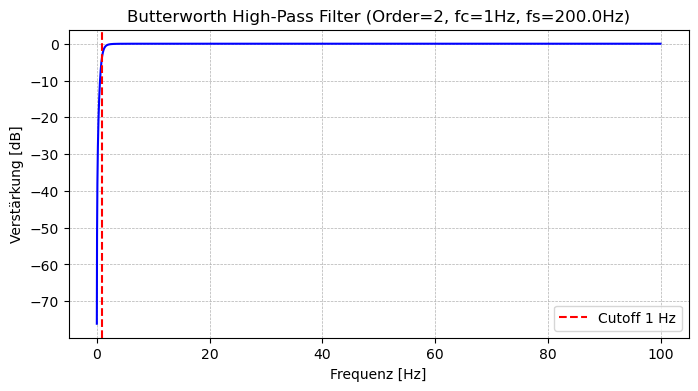

In [35]:
### kurzer exkurs für signalfilterung "Butterworth"
# Samplingrate
fs = 200.0   # Hz (weil STEPS = 5ms)
nyquist = fs / 2.0

# Filterparameter
fc = 1     # Cutoff-Frequenz (Hz)
order = 2   # Filterordnung

# Butterworth High-Pass Filter designen
Wn = fc / nyquist   # normierte Grenzfrequenz
b, a = butter(order, Wn, btype="highpass")

print("Filterkoeffizienten:")
print("b =", b)
print("a =", a)

# Frequenzgang berechnen
w, h = freqz(b, a, worN=8000)
frequencies = (w / np.pi) * nyquist  # zurück in Hz

# Plot
plt.figure(figsize=(8,4))
plt.plot(frequencies, 20*np.log10(abs(h)), 'b')
plt.axvline(fc, color='r', linestyle='--', label=f'Cutoff {fc} Hz')
plt.title(f'Butterworth High-Pass Filter (Order={order}, fc={fc}Hz, fs={fs}Hz)')
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Verstärkung [dB]')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
### Magnitude mit Hochpassfilter um Gravitation und langsame Bewegungen zu entfernen

# Samplingrate bekannt
fs = 200.0     # Hz
fc = 0.5       # Cutoff-Frequenz
order = 2      # Filterordnung

# Filterdesign (Butterworth Highpass)
b, a = butter(order, fc/(fs/2), btype="highpass")

# Magnitude-Zeitreihe global berechnen
mag_series = np.sqrt(sensor_df["x"]**2 + sensor_df["y"]**2 + sensor_df["z"]**2)

# Hochpass gefilterte Magnitude
mag_hp_series = pd.Series(filtfilt(b, a, mag_series), index=mag_series.index)

# Jetzt pro Fenster RMS auf gefilterte Werte
mag_rms_hp_vals = []
for t0, tmid in zip(accelerometer_features.index, accelerometer_features["t_mid"]):
    t1 = (t0 + L) - pd.Timedelta(nanoseconds=1)   # rechts-offen
    chunk = mag_hp_series.loc[t0:t1].to_numpy()
    if len(chunk) > 0:
        mag_rms_hp_vals.append(float(np.sqrt(np.mean(chunk**2))))
    else:
        mag_rms_hp_vals.append(np.nan)

# Neue Spalte hinzufügen
accelerometer_features["mag_rms_hp"] = mag_rms_hp_vals

accelerometer_features.head(10)

,t_mid,mag_rms,mag_rms_dc,mag_rms_hp
t_start,,,,
2025-08-19 11:26:59.695000+00:00,2025-08-19 11:27:00.695000+00:00,0.377984,0.248570,0.223442
2025-08-19 11:27:00.695000+00:00,2025-08-19 11:27:01.695000+00:00,0.432967,0.278692,0.273197
2025-08-19 11:27:01.695000+00:00,2025-08-19 11:27:02.695000+00:00,0.328157,0.198745,0.206749
2025-08-19 11:27:02.695000+00:00,2025-08-19 11:27:03.695000+00:00,1.612042,1.340639,0.749149
2025-08-19 11:27:03.695000+00:00,2025-08-19 11:27:04.695000+00:00,7.710439,5.817743,3.692870
2025-08-19 11:27:04.695000+00:00,2025-08-19 11:27:05.695000+00:00,17.918632,10.607268,8.155123
2025-08-19 11:27:05.695000+00:00,2025-08-19 11:27:06.695000+00:00,18.011544,10.487334,8.367161
2025-08-19 11:27:06.695000+00:00,2025-08-19 11:27:07.695000+00:00,10.481428,6.586735,6.287244
2025-08-19 11:27:07.695000+00:00,2025-08-19 11:27:08.695000+00:00,10.203316,6.000420,5.726872
